# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)
import scipy
import seaborn as sns
from statsmodels.formula.api import ols

In [2]:
from Functions import get_param_names, get_category_dict, get_ages_cols

## Directories etc.

In [3]:
data_save_path = "C:/Users/maria/MEGAsync/SLCNdata/Meta/all_data"
plot_save_path = "C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots"
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)

# Get data

In [4]:
all_data = pd.read_csv(os.path.join(data_save_path, 'all_data.csv'), index_col=0)
all_data_z = pd.read_csv(os.path.join(data_save_path, 'all_data_z.csv'), index_col=0)
all_data_long = pd.read_csv(os.path.join(data_save_path, 'all_data_long.csv'), index_col=0)
all_data_long_z = pd.read_csv(os.path.join(data_save_path, 'all_data_long_z.csv'), index_col=0)

In [5]:
param_cols = [c for c in all_data.columns for p in get_param_names() if p in c]
ages_cols = get_ages_cols()
category_dict = get_category_dict()

## Correlation between features

In [6]:
x_ticks = []
vlines = []
new_line = 0
for cols in category_dict.values():
    x_ticks += cols
    new_line += len(cols)
    vlines += [new_line]

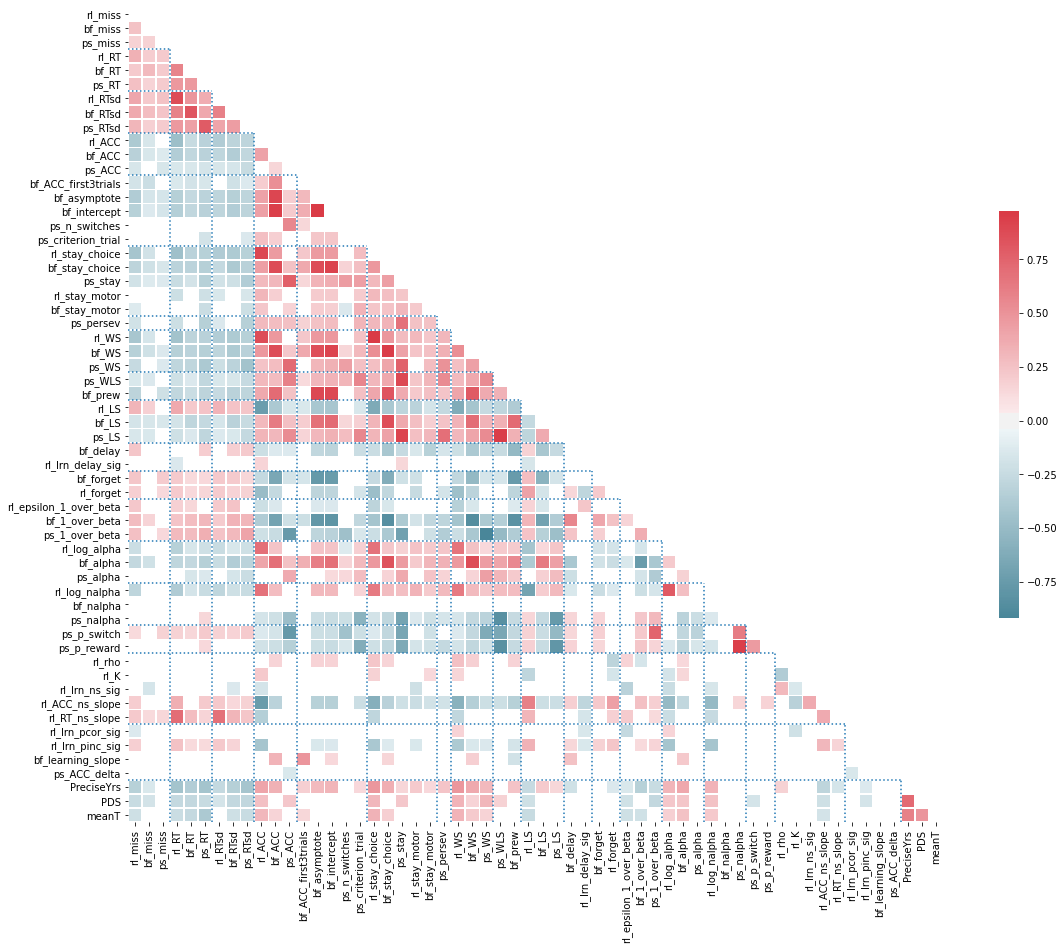

In [32]:
# Compute the correlation matrix
crit_p = 0.05
sub_dat = all_data[x_ticks + ['PreciseYrs', 'PDS', 'meanT']]
spearman = scipy.stats.spearmanr(sub_dat, nan_policy='omit')
corr = spearman.correlation
corr = pd.DataFrame(corr, columns=sub_dat.columns, index=sub_dat.columns)

# Generate a mask for the upper triangle
triangle_mask = np.triu(np.ones_like(corr, dtype=np.bool))
sig_mask = spearman.pvalue < crit_p
mask = np.invert(sig_mask * np.invert(triangle_mask))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.hlines(y=vlines, xmin=0, xmax=vlines, linestyle='dotted')
ax.vlines(x=vlines, ymin=ax.get_ylim()[0], ymax=vlines, linestyle='dotted')
plt.savefig(os.path.join(plot_save_path, '2_CorrMatrix.png'))
plt.savefig(os.path.join(plot_save_path, '2_CorrMatrix.svg'))

## R2R-requested correlations

In [36]:
p_pd = spearman.pvalue
p_pd = pd.DataFrame(p_pd, columns=sub_dat.columns, index=sub_dat.columns)
p_pd.head()

,rl_miss,bf_miss,ps_miss,rl_RT,bf_RT,ps_RT,rl_RTsd,bf_RTsd,ps_RTsd,rl_ACC,...,rl_lrn_ns_sig,rl_ACC_ns_slope,rl_RT_ns_slope,rl_lrn_pcor_sig,rl_lrn_pinc_sig,bf_learning_slope,ps_ACC_delta,PreciseYrs,PDS,meanT
rl_miss,0.000000e+00,0.000056,0.006089,2.302412e-08,7.771875e-04,4.123531e-05,4.857628e-11,2.942011e-10,5.759672e-07,4.771219e-10,...,0.194205,2.523642e-03,6.408682e-04,0.041101,0.003220,0.520593,0.969740,8.883597e-08,0.003658,0.003961
bf_miss,5.586191e-05,0.000000,0.007434,1.734603e-03,4.010211e-06,1.015384e-02,5.940569e-04,8.705482e-06,3.990527e-03,9.924045e-03,...,0.008223,3.854372e-01,4.991955e-02,0.990803,0.240570,0.907884,0.637086,2.197394e-02,0.028636,0.127701
ps_miss,6.088535e-03,0.007434,0.000000,8.022219e-04,9.331697e-04,1.162216e-03,5.319857e-05,1.388793e-04,1.313307e-03,5.566718e-02,...,0.076111,2.268298e-01,2.519584e-02,0.270094,0.202132,0.497135,0.233847,3.918906e-01,0.592751,0.550881
rl_RT,2.302412e-08,0.001735,0.000802,0.000000e+00,2.446295e-23,2.250699e-15,1.907892e-80,2.960525e-24,5.679835e-15,1.959020e-14,...,0.723768,1.780147e-08,3.932548e-38,0.333858,0.000069,0.287992,0.371430,3.202961e-12,0.001689,0.000927
bf_RT,7.771875e-04,0.000004,0.000933,2.446295e-23,0.000000e+00,4.352694e-15,2.409163e-16,2.488353e-62,9.641816e-13,6.184940e-05,...,0.177485,6.145439e-02,1.366523e-05,0.466980,0.041893,0.203657,0.957095,1.227848e-08,0.001153,0.000179


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\2_corr_bf_forget_bf_alpha.svg
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\2_corr_bf_forget_bf_alpha.png


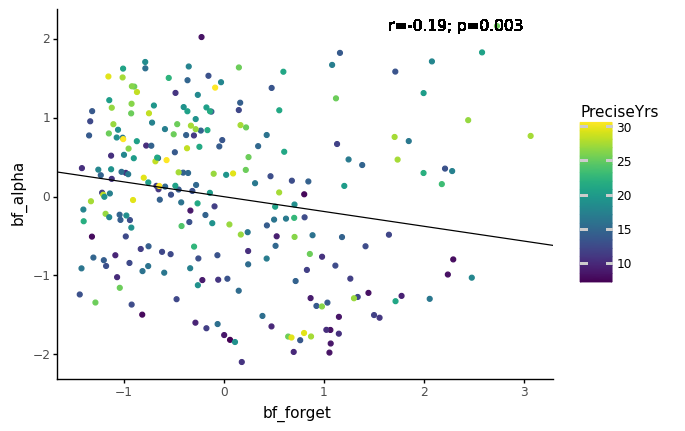

<ggplot: (193451698074)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\2_corr_rl_forget_rl_log_alpha.svg
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\2_corr_rl_forget_rl_log_alpha.png


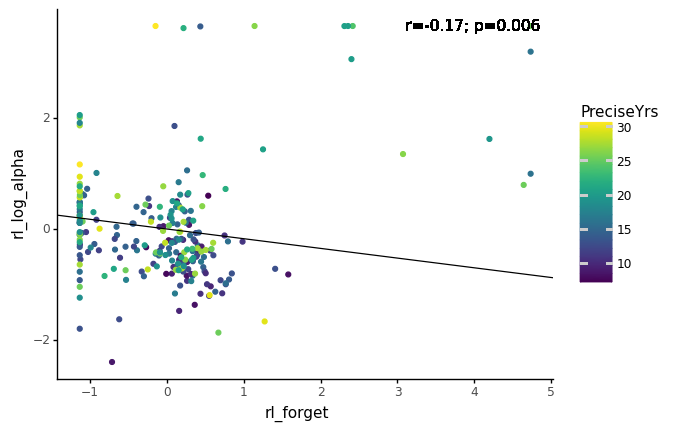

<ggplot: (193454645212)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\2_corr_rl_K_rl_log_alpha.svg
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\2_corr_rl_K_rl_log_alpha.png


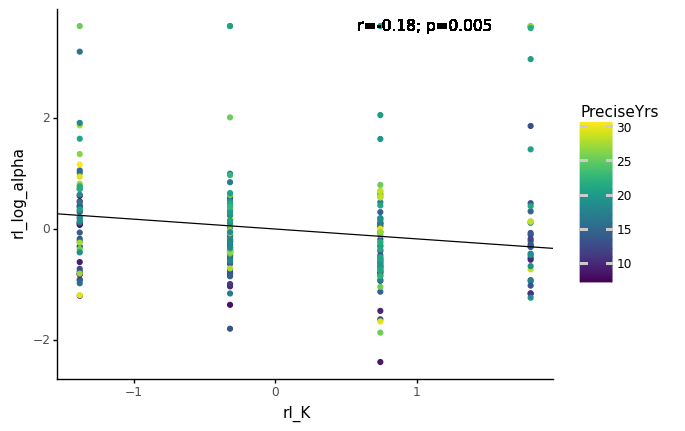

<ggplot: (193453336950)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\2_corr_bf_forget_rl_forget.svg
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\2_corr_bf_forget_rl_forget.png


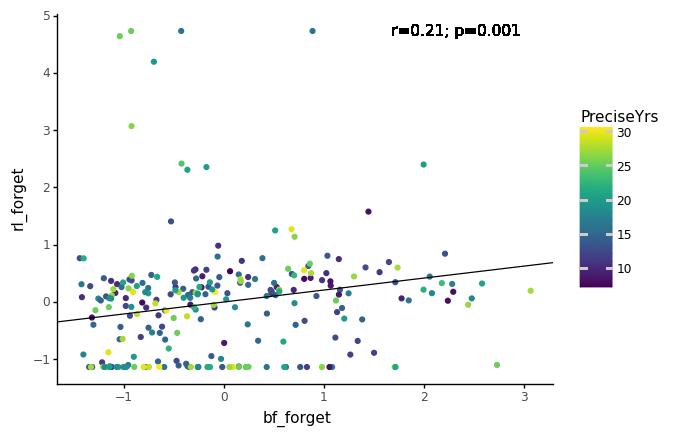

<ggplot: (193452684716)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\2_corr_bf_alpha_rl_log_alpha.svg
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\2_corr_bf_alpha_rl_log_alpha.png


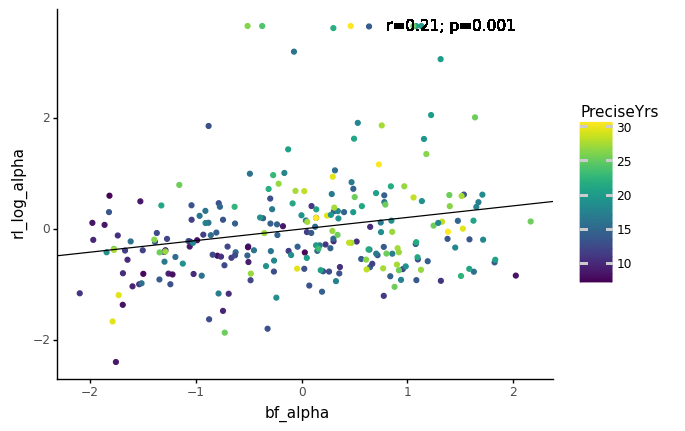

<ggplot: (193453258382)>


In [84]:
# Correlation between forget and alpha within tasks
dat = all_data_z
for x_col, y_col in (('bf_forget', 'bf_alpha'), ('rl_forget', 'rl_log_alpha'), ('rl_K', 'rl_log_alpha'), ('bf_forget', 'rl_forget'), ('bf_alpha', 'rl_log_alpha')):
    
    text = ('r={}; p={}'.format(
        np.round(corr[x_col][y_col], 2),
        np.round(p_pd[x_col][y_col], 3)))
    
    g = (gg.ggplot(dat, gg.aes(x_col, y_col, color='PreciseYrs'))
         + gg.geom_point()
         + gg.geom_text(x=max(dat[x_col]) - 0.75, y=max(dat[y_col]), color='black', label=text)
    #      + gg.geom_smooth(method='lm')  # issue here: uses pearson, not spearman
         + gg.geom_abline(
             intercept=np.mean(dat[y_col]),
             slope=scipy.stats.spearmanr(dat[x_col], dat[y_col]).correlation)
    )
    
    g.save(os.path.join(plot_save_path, '2_corr_{}_{}.svg'.format(x_col, y_col)))
    g.save(os.path.join(plot_save_path, '2_corr_{}_{}.png'.format(x_col, y_col)))
    print(g)

In [8]:
# Same for age-cleaned residuals
all_data['PreciseYrs2'] = np.square(all_data['PreciseYrs'])
ages_cols += ['PreciseYrs2']
resid_dat = pd.DataFrame()

for outcome in [c for c in sub_dat.columns.values if not c in ages_cols]:
    
    # Run regression
    formula = '{} ~ PreciseYrs + PreciseYrs2'.format(outcome)
    fit = ols(data=all_data, formula=formula).fit()

    # Get residuals
    resid_row = pd.DataFrame(fit.resid).T
    resid_row.index = ['resid_{}'.format(outcome)]

    resid_dat = resid_dat.append(resid_row)

resid_dat = resid_dat.T
resid_dat

,resid_rl_miss,resid_bf_miss,resid_ps_miss,resid_rl_RT,resid_bf_RT,resid_ps_RT,resid_rl_RTsd,resid_bf_RTsd,resid_ps_RTsd,resid_rl_ACC,...,resid_ps_p_reward,resid_rl_rho,resid_rl_K,resid_rl_lrn_ns_sig,resid_rl_ACC_ns_slope,resid_rl_RT_ns_slope,resid_rl_lrn_pcor_sig,resid_rl_lrn_pinc_sig,resid_bf_learning_slope,resid_ps_ACC_delta
0,-0.000651,-0.015932,0.003753,0.160540,-0.135320,0.081130,0.221012,-0.235502,0.001172,0.083125,...,0.049902,0.153054,-0.044183,0.025987,-0.124381,0.364997,-0.032184,-0.025586,2.014237,0.090096
1,-0.002147,-0.007353,-0.001073,-0.121527,-0.100113,0.093777,-0.159208,-0.199361,0.041850,0.066750,...,-0.068710,0.083671,0.730853,-0.070978,-0.096378,-0.329501,-0.028413,0.040432,-0.826841,-0.034060
2,-0.001171,-0.004271,-0.000578,-0.165135,-0.231477,-0.137056,-0.191062,-0.138209,-0.140127,0.096858,...,0.024186,0.036003,1.658410,0.078639,-0.469707,-0.526671,0.004723,0.060507,-0.747229,0.041439
3,-0.000412,-0.001807,-0.000246,0.101444,0.351712,0.049250,0.119488,0.429730,0.025119,-0.026517,...,-0.028071,0.062834,-0.392035,-0.145264,0.073428,0.213421,-0.019709,0.075782,-0.683333,-0.107988
4,-0.003031,-0.010105,-0.001558,-0.057454,0.270119,0.016600,0.023049,0.063945,-0.018863,0.126273,...,0.056722,-0.228815,1.800305,-0.076871,-0.369525,-0.599592,0.037927,-0.055168,-0.004502,-0.109395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,0.000432,0.001433,-0.000317,-0.100733,0.048911,0.156353,-0.149895,-0.007106,0.093357,-0.006100,...,0.009040,0.160475,-0.400443,-0.060057,-0.100827,-0.191295,-0.023514,-0.099159,4.730247,0.019118
243,0.000362,0.000923,-0.000101,-0.074491,-0.216063,-0.143204,-0.050092,-0.219320,-0.084324,0.022922,...,0.025075,-0.781072,1.577393,0.030936,0.062696,-0.006739,-0.101365,-0.071129,-0.602885,-0.031762
244,0.000170,0.000185,-0.000084,0.166027,0.177235,0.180497,0.376619,0.274061,0.127631,0.039043,...,0.070989,-0.037631,1.579270,-0.100969,-0.211707,-0.052244,-0.019341,0.046737,0.487276,0.017758
245,0.002581,0.001400,0.006162,0.075097,1.055248,0.087472,0.196937,1.006676,0.024090,-0.017155,...,0.037716,0.055915,1.591882,-0.004243,-0.107117,-0.059057,0.004197,0.021228,0.561833,0.100325


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide


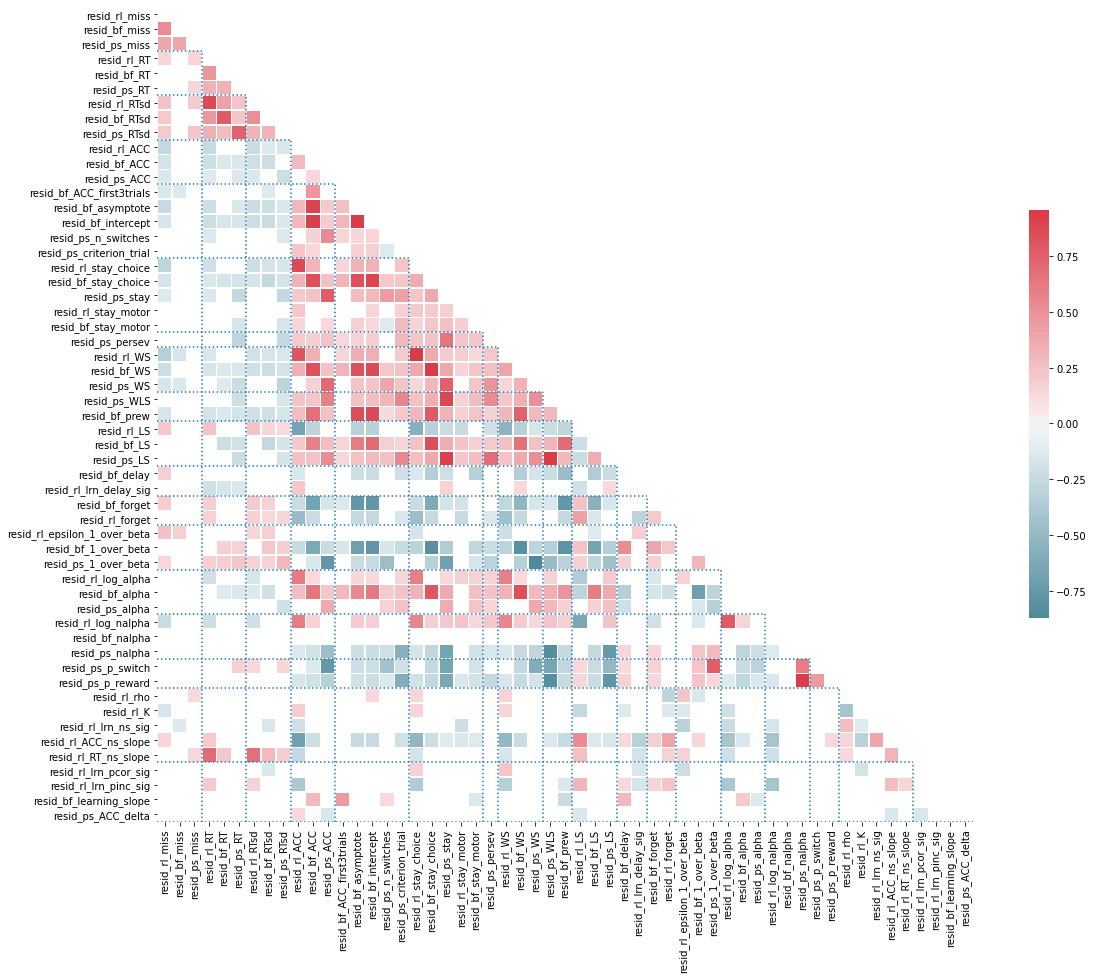

In [9]:
spearman_resid = scipy.stats.spearmanr(resid_dat, nan_policy='omit')
resid_corr = spearman_resid.correlation
resid_corr = pd.DataFrame(resid_corr, columns=resid_dat.columns, index=resid_dat.columns)

# Generate a resid_mask for the upper triangle
triangle_resid_mask = np.triu(np.ones_like(resid_corr, dtype=np.bool))
sig_resid_mask = spearman_resid.pvalue < crit_p
resid_mask = np.invert(sig_resid_mask * np.invert(triangle_resid_mask))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the resid_mask and resid_correct aspect ratio
ax = sns.heatmap(resid_corr, mask=resid_mask, cmap=cmap, center=0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.hlines(y=vlines, xmin=0, xmax=vlines, linestyle='dotted')
ax.vlines(x=vlines, ymin=ax.get_ylim()[0], ymax=vlines, linestyle='dotted')
plt.savefig(os.path.join(plot_save_path, '2_Residresid_corrMatrix.png'))

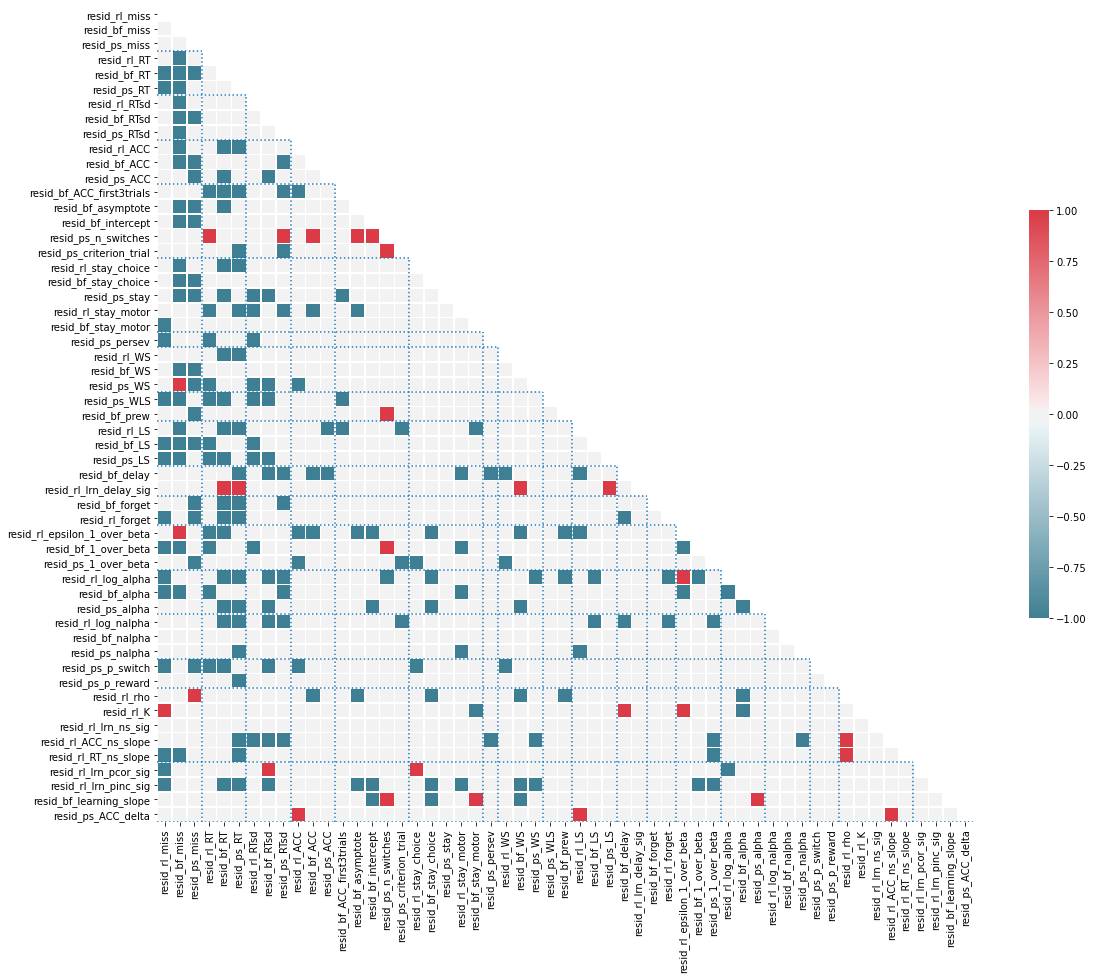

In [10]:
# Difference between raw data and diffuals
diff = pd.DataFrame(mask[:resid_mask.shape[0], :resid_mask.shape[1]].astype(int) - resid_mask.astype(int),
                    dtype=float,  # if datatype is not float, heatmap doesn't work
                    index=resid_corr.columns, columns=resid_corr.columns)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot
ax = sns.heatmap(diff, mask=triangle_resid_mask, cmap=cmap, center=0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.hlines(y=vlines, xmin=0, xmax=vlines, linestyle='dotted')
ax.vlines(x=vlines, ymin=ax.get_ylim()[0], ymax=vlines, linestyle='dotted')
plt.savefig(os.path.join(plot_save_path, '2_DiffMatrix.png'))

# OLD

In [11]:
# # Correlations between ACCs and RTs in different tasks
# rt_cols = [col for col in all_data.columns if
#            ('RT' in col) and ('sd' not in col) and ('delta' not in col) and ('minus' not in col)]
# rtsd_cols = [col for col in all_data.columns if 'RTsd' in col]
# acc_cols = [col for col in all_data.columns if
#             ('ACC' in col) and ('delta' not in col) and ('minus' not in col)]

# # Compute the correlation matrix
# dat = all_data[acc_cols + rt_cols + rtsd_cols + ['PreciseYrs']]
# corr = scipy.stats.spearmanr(dat, nan_policy='omit').correlation
# corr = pd.DataFrame(corr, columns=dat.columns, index=dat.columns)

# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=np.bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(20, 15))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmax=1, vmin=-1,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})
# plt.savefig(os.path.join(plot_save_path, '2_CorrMatrixAccRt.png'))

In [12]:
# # Correlations between parameters in different tasks
# param_cols_by_param = [
#     p for p in param_cols if 'beta' in p] + [
#     p for p in param_cols if 'alpha' in p] + [
#     p for p in param_cols if 'persev' in p] + [
#     p for p in param_cols if 'forget' in p] + [
#     p for p in param_cols if ('beta' not in p) and ('alpha' not in p) and ('persev' not in p) and ('forget' not in p)
# ]

# # Compute the correlation matrix
# dat = all_data[param_cols_by_param + ['PreciseYrs']]
# corr = scipy.stats.spearmanr(dat, nan_policy='omit').correlation
# corr = pd.DataFrame(corr, columns=dat.columns, index=dat.columns)

# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=np.bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(20, 15))

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmax=1, vmin=-1,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})
# plt.savefig(os.path.join(plot_save_path, '2_CorrMatrixPar.png'))